cars: 8792, not-cars: 8968


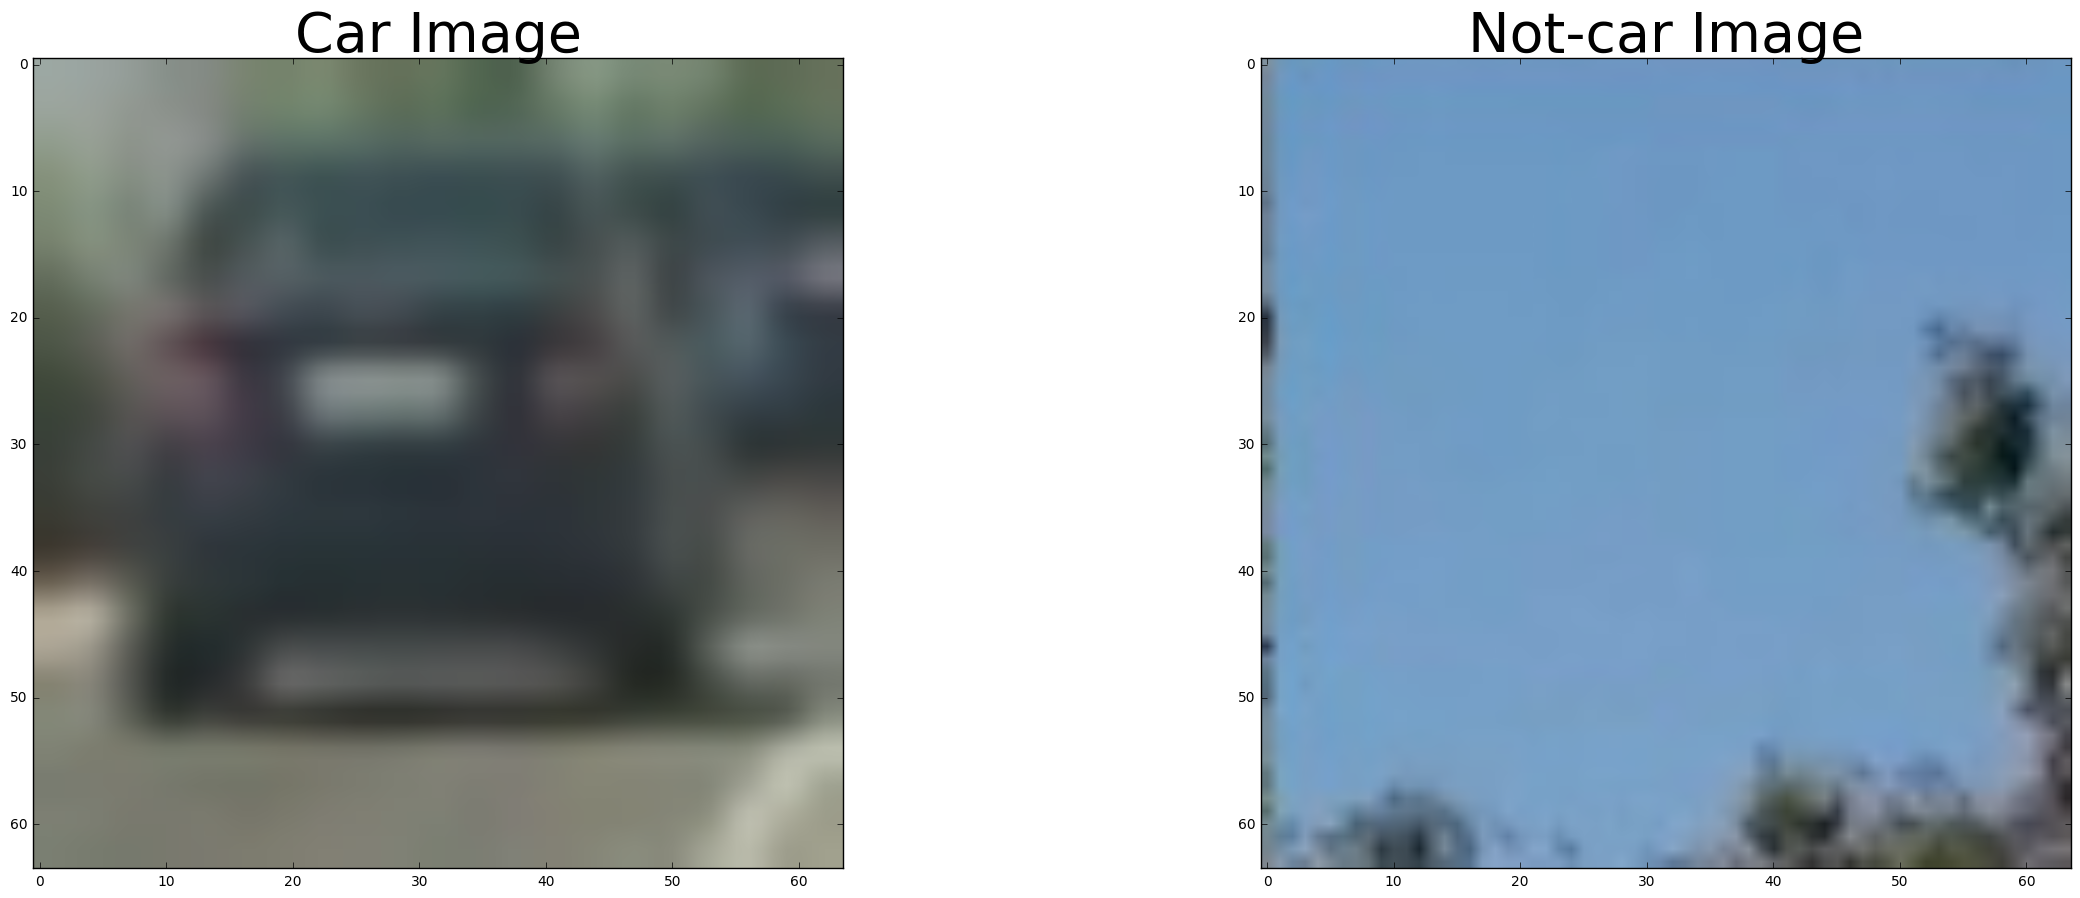

In [19]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import os
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

%matplotlib inline

def show_image_comparison(img1, img2, title1=None, title2=None, cmap="jet"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1, cmap=cmap)
    ax2.imshow(img2, cmap=cmap)
    if title1 is not None:
        ax1.set_title(title1, fontsize=40)
    if title2 is not None:
        ax2.set_title(title2, fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
                          
def recursive_image_filenames(path, extension='.png'):
    results = []
    for root, subdirs, files in os.walk(path):
        for filename in files: 
            if filename.endswith(extension):
                results.append(os.path.join(root, filename))
    return results

# Get list of training images
cars = recursive_image_filenames('training/vehicles')
notcars = recursive_image_filenames('training/non-vehicles')

print('cars: {}, not-cars: {}'.format(len(cars), len(notcars)))

car_img = mpimg.imread(cars[0])
notcar_img = mpimg.imread(notcars[0])
show_image_comparison(car_img, notcar_img, title1='Car Image', title2='Not-car Image')


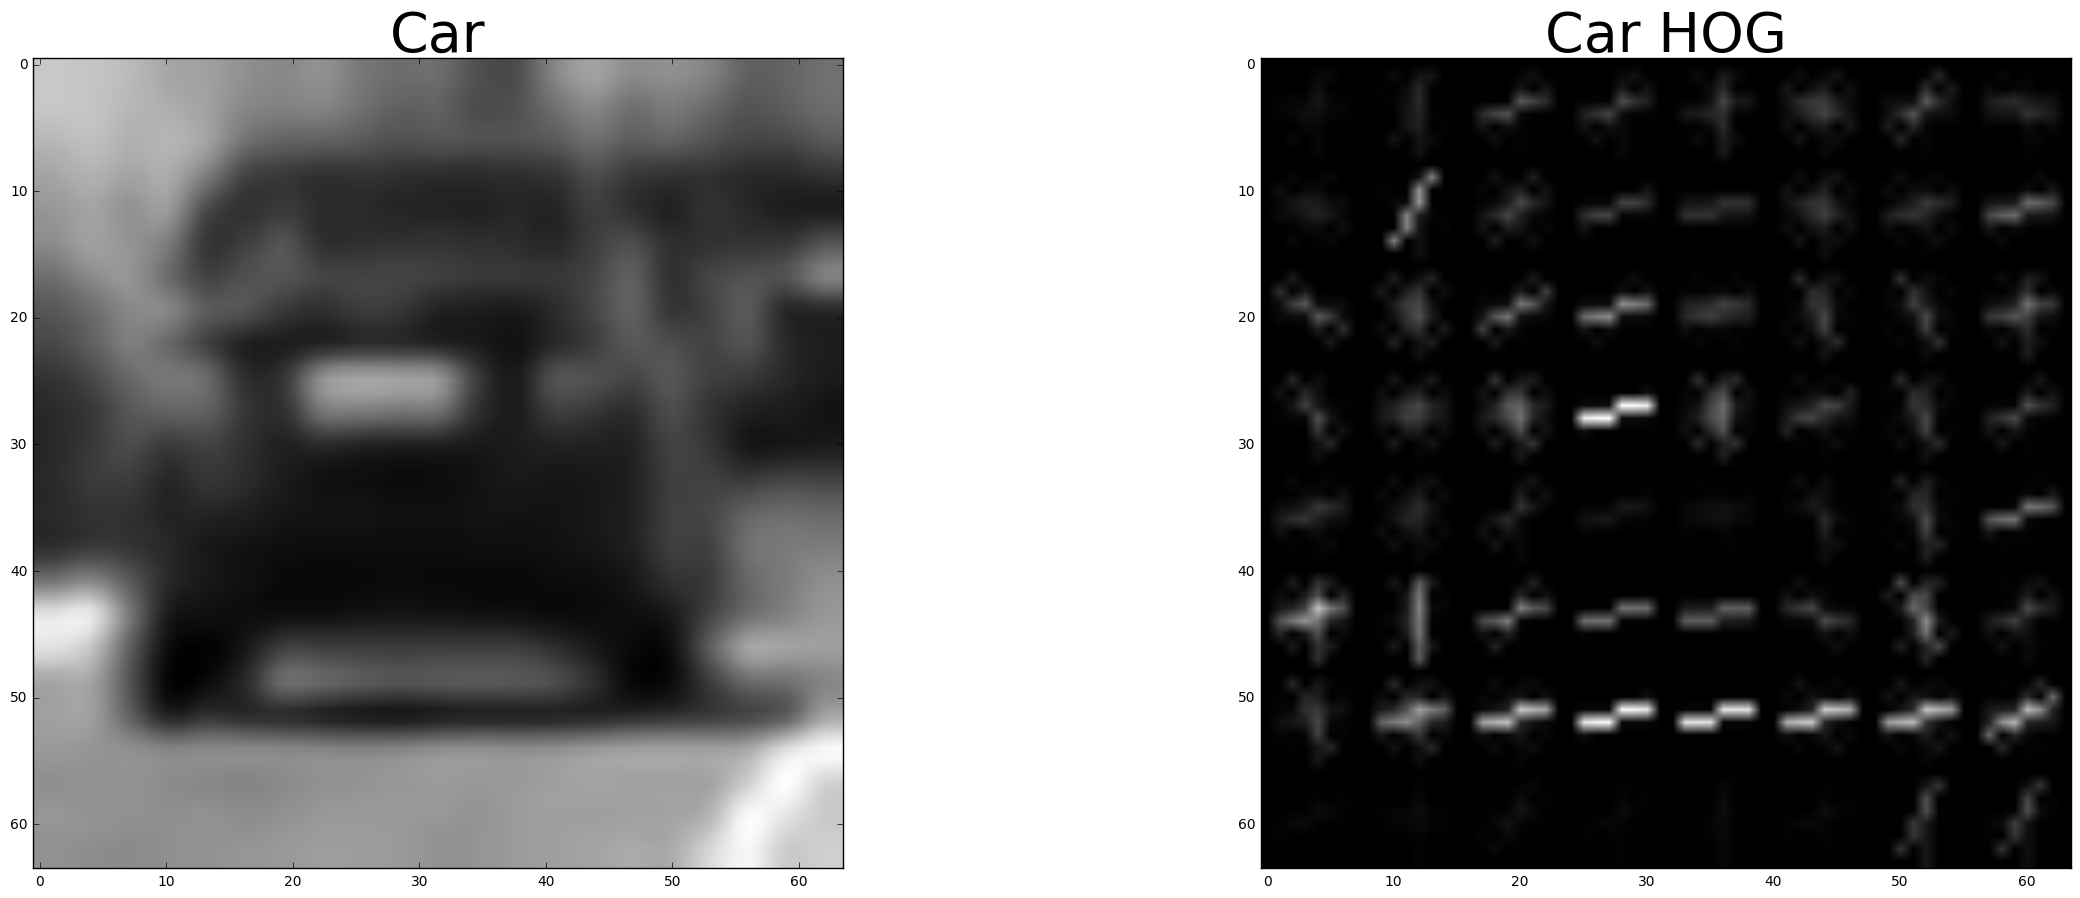

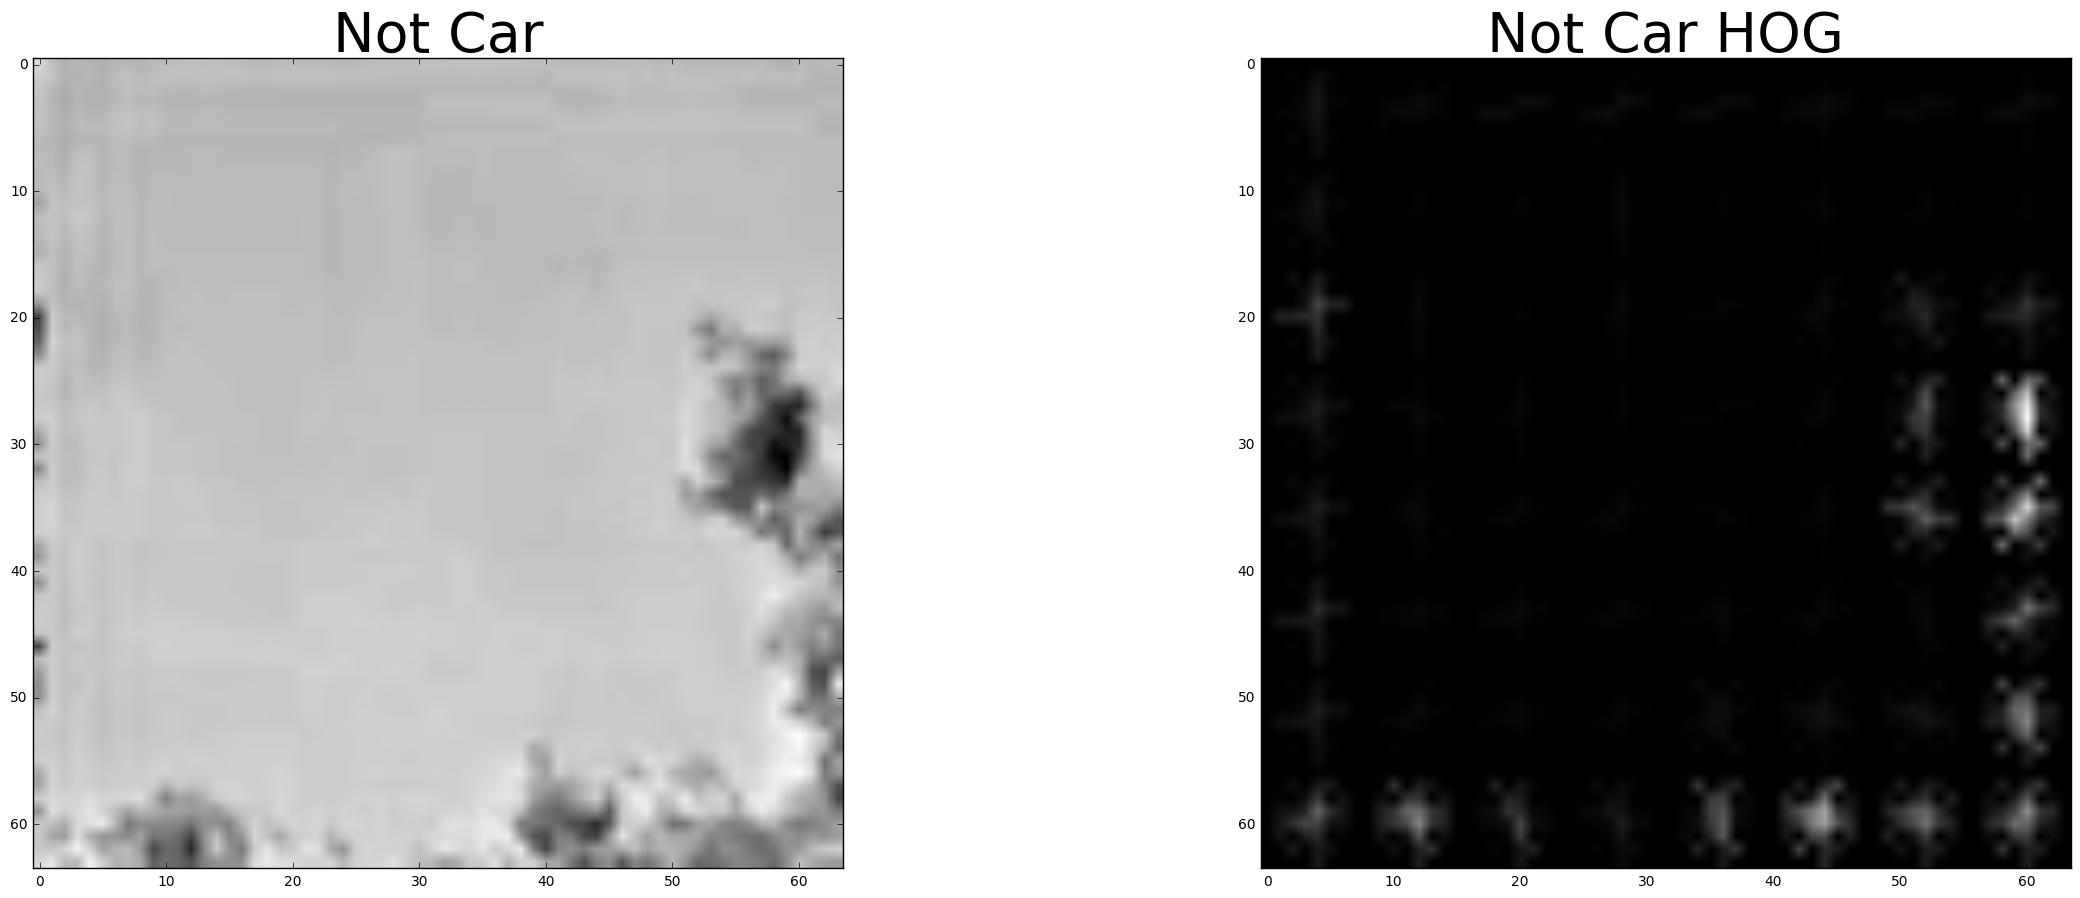

In [23]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    conversions = {
        'HSV': cv2.COLOR_RGB2HSV,
        'LUV': cv2.COLOR_RGB2LUV,
        'HLS': cv2.COLOR_RGB2HLS,
        'YUV': cv2.COLOR_RGB2YUV,
        'YCrCb': cv2.COLOR_RGB2YCrCb,
    }
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        conversion = conversions[cspace]
        if conversion is not None:
            feature_image = cv2.cvtColor(image, conversion)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

### Feature extraction parameters
colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL" (for best results)

# Sample hog image visualtions
car_img_ch0 = car_img[:,:,0]
features, hog_image = get_hog_features(car_img_ch0, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
show_image_comparison(car_img_ch0, hog_image, title1='Car', title2='Car HOG', cmap='gray')

notcar_img_ch0 = notcar_img[:,:,0]
features, hog_image = get_hog_features(notcar_img_ch0, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
show_image_comparison(notcar_img_ch0, hog_image, title1='Not Car', title2='Not Car HOG', cmap='gray')


In [ ]:
t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Save classifier model
from sklearn.externals import joblib
joblib.dump(svc, 'linear-svc.pkl') 
print('Saved model')


In [16]:
# Load the classifier model
svc = joblib.load('linear-svc.pkl')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9789
My SVC predicts:  [ 1.  1.  0.  1.  0.  1.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  1.  1.  0.  1.  1.]
0.00205 Seconds to predict 10 labels with SVC
